# 完整的客户分群分析项目

项目介绍:
- 客户分群（Cohort分析）和RFM分析（Recency-Frequency-Monetary）   
- 电商/零售领域最常用的分析方法，对应真实业务场景（用户分层、精准营销）。

In [10]:
# 读取文件:
# 文件OnlineRetail.csv
import pandas as pd
import numpy as np
# 具体是 0xa3 这个字节，它通常对应英镑符号 £ 在 ISO-8859-1 或 Windows-1252 编码中的表
df = pd.read_csv('OnlineRetail.csv', encoding='latin-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [11]:
print(df.describe())

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


In [12]:
df.head()
   # InvoiceNo: 发票编号
   # StockCode: 商品编号
   # Description: 商品描述
   # Quantity: 数量
   # InvoiceDate: 发票日期
   # UnitPrice: 单价
   # CustomerID: 顾客ID
   # Country: 国家

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 数据清洗:

In [14]:
# 1. 基础清洗
print(f"原始数据量: {len(df)}")
df = df.dropna(subset=['CustomerID'])          # 删除无客户ID的记录
df = df[df['Quantity'] > 0]                    # 删除退货/负数量记录
df = df[df['UnitPrice'] > 0]                       # 删除异常价格记录

# 2. 创建关键字段
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']  # 计算每笔交易金额
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # 转换日期格式

# 3. 过滤测试数据
df = df[~df['StockCode'].str.contains('TEST', na=False)]

print(f"清洗后数据量: {len(df)}")
print(f"时间范围: {df['InvoiceDate'].min()} 至 {df['InvoiceDate'].max()}")

原始数据量: 541909
清洗后数据量: 397884
时间范围: 2010-12-01 08:26:00 至 2011-12-09 12:50:00


            Quantity      UnitPrice     TotalPrice
count  397884.000000  397884.000000  397884.000000
mean       12.988238       3.116488      22.397000
std       179.331775      22.097877     309.071041
min         1.000000       0.001000       0.001000
25%         2.000000       1.250000       4.680000
50%         6.000000       1.950000      11.800000
75%        12.000000       3.750000      19.800000
max     80995.000000    8142.750000  168469.600000


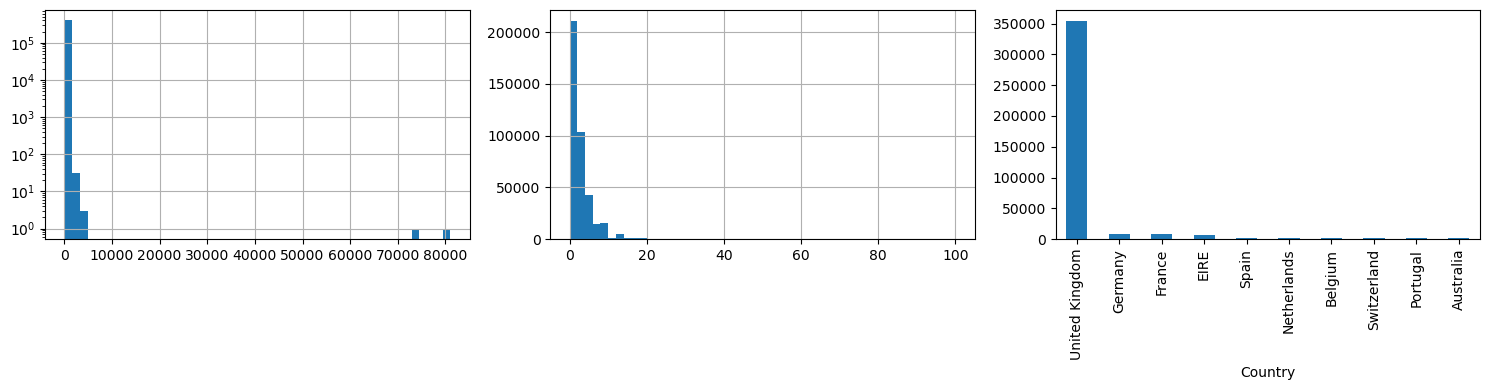

In [17]:
# 基础统计
print(df[['Quantity', 'UnitPrice', 'TotalPrice']].describe())

# 关键字段分布检查
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15,4))
df['Quantity'].hist(bins=50, ax=ax[0], log=True)  # 对数坐标
df['UnitPrice'].hist(bins=50, ax=ax[1], range=(0,100)) # 排除极端值
df['Country'].value_counts().head(10).plot(kind='bar', ax=ax[2])
plt.tight_layout()

In [21]:
# 创建交易级视图（RFM分析用）
transactions = df.groupby(['InvoiceNo', 'CustomerID', 'InvoiceDate']).agg({
    'TotalPrice': 'sum'
}).reset_index()

In [23]:
# 创建客户级视图（Cohort分析用）
customer_df = df.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max', 'nunique'],  # 首次/末次购买时间，订单数
    'TotalPrice': 'sum'                       # 总消费金额
})
customer_df.columns = ['FirstPurchase', 'LastPurchase', 'OrderCount', 'TotalSpent']

In [24]:
# 保存清洗后主数据
df.to_parquet('retail_cleaned.parquet')  # 比CSV更快更小

# 保存分析专用视图
transactions.to_csv('transactions_view.csv', index=False)
customer_df.to_csv('customer_view.csv')

print("数据准备完成！可进行下一步分析")

数据准备完成！可进行下一步分析


## Cohort分析

将用户按首次行为时间分组，追踪各组随时间的留存变化。
- 群组(Cohort)：同一时间段首次购买的用户群体
- 留存率(Retention)：群组中后续继续购买的用户比例
- 业务价值：识别用户流失模式，优化产品迭代和营销策略

In [27]:
import pandas as pd
import numpy as np
import plotly.express as px

# 加载清洗后的数据
df = pd.read_parquet('retail_cleaned.parquet')

In [28]:
# 创建购买月份字段
df['OrderMonth'] = df['InvoiceDate'].dt.to_period('M')

# 确定每个客户的首次购买月份（群组）
cohorts = df.groupby('CustomerID')['OrderMonth'].min().reset_index()
cohorts.columns = ['CustomerID', 'CohortMonth']

# 将群组信息合并到原始数据
df = df.merge(cohorts, on='CustomerID')

In [30]:
# 计算月份间隔（首次购买后第几个月）
df['CohortIndex'] = (df['OrderMonth'] - df['CohortMonth']).apply(lambda x: x.n)

# 创建留存透视表
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot_table(
    index='CohortMonth',
    columns='CohortIndex',
    values='CustomerID'
)

# 计算留存率（以首月为基准）
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

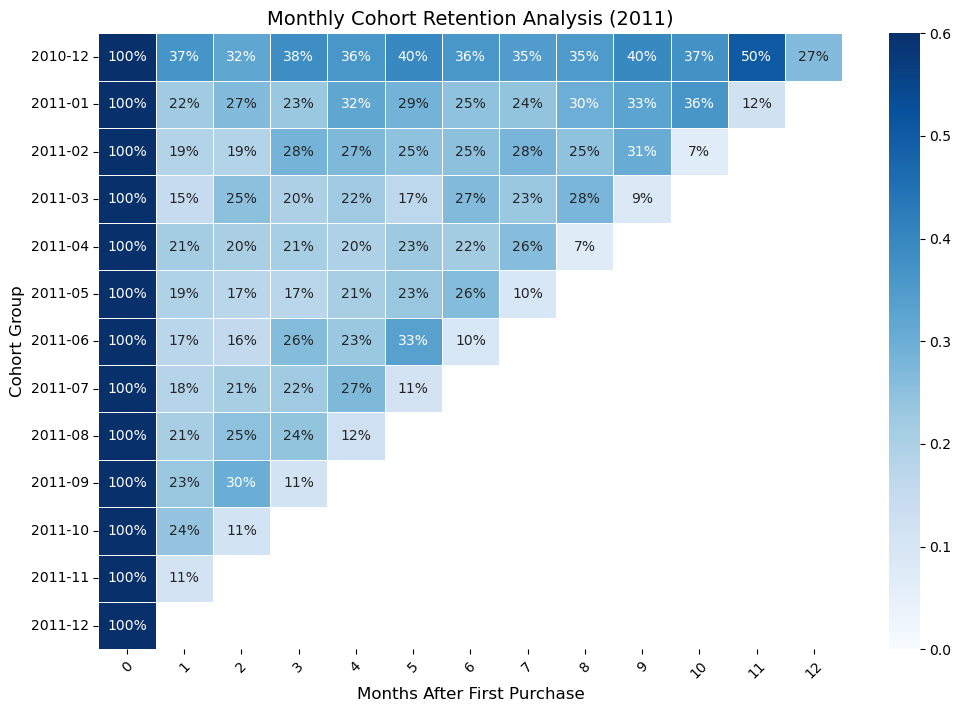

In [44]:
import seaborn as sns
# 转换留存矩阵为长格式
retention_long = retention_matrix.reset_index().melt(
    id_vars='CohortMonth', 
    var_name='MonthsAfterFirst', 
    value_name='RetentionRate'
)

# 创建带数值标签的热力图
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    retention_matrix,
    annot=True,  # 显示数值
    fmt=".0%",   # 百分比格式
    cmap="Blues",
    vmin=0,
    vmax=0.6,    # 扩展颜色范围
    linewidths=0.5
)

# 优化标签
ax.set_title('Monthly Cohort Retention Analysis (2011)', fontsize=14)
ax.set_xlabel('Months After First Purchase', fontsize=12)
ax.set_ylabel('Cohort Group', fontsize=12)

# 旋转X轴标签
plt.xticks(rotation=45)

# 保存高质量图片
plt.savefig('cohort_retention_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

### 异常点：
  - 2011年3月群组（2011-03）的次月留存率最低，只有15%。
  - 2011年11月群组（2011-11）的次月留存率也很低，为11%，但注意这个群组只有两个月的数据（首月和次月）。
### 结论：
1. 次月留存率普遍较低（大部分在15%-24%之间），说明新用户在首月购买后的流失率很高。需要重点关注新用户的留存，尤其是第一个月到第二个月的留存策略。
2. 长期留存（第三个月及以后）的留存率在20%-30%左右波动，但不同群组差异较大，有些月份会出现较高的留存率（如2010-12群组的第11个月达到50%），但也有一些月份会突然降低（如2011-06群组的第七个月降到10%）。这可能与季节性活动、促销或产品改进有关。
3. 异常群组分析：
    - 2011年3月群组：次月留存率最低（15%），需要排查该月是否有异常情况（如产品质量问题、物流问题、负面事件等）。
    - 2011年11月群组：次月留存率也很低（11%），可能受到年末假期（如黑色星期五、圣诞节）的影响，用户可能被竞争对手的促销活动吸引而流失。
4. 留存率波动：从数据来看，留存率并没有呈现持续下降的趋势，而是在某些月份会回升，说明用户的复购行为可能受到运营活动的影响。因此，可以通过策划复购活动来提升留存。
### 建议：
  1. 提升新用户体验：针对首月到次月的高流失，优化新用户引导流程，增加新用户专属优惠，加强首次购买后的客户关怀（如售后跟进、满意度调查等）。
  2. 针对异常群组进行深入分析：对于2011年3月和11月群组，分析具体原因，并制定相应的预防措施。
  3. 设计长期留存策略：对于已经留存超过2个月的用户，可以通过会员计划、积分体系、定期促销活动等提高他们的忠诚度。
  4. 监控留存数据：持续跟踪各群组的留存情况，及时发现异常并调整策略。
 注意：由于2010-12群组的数据表现相对较好（长期留存率稳定在30%-40%），可以研究该群组当时的运营策略，借鉴成功经验。

最差表现：2011年11月群组仅11%次月留存
可能原因：    
- 新用户体验不佳（注册/首单流程复杂）  
- 缺乏有效的用户激活策略   
- 首单后缺乏跟进互动
#### 业务价值
定位流失节点：可观察用户通常在第几个月开始大量流失（比如多数 Cohort 在 Month 3 后留存率跳水，说明用户 “3 个月后流失” 是关键节点，需针对性优化）。
评估用户质量：对比不同 Cohort 的留存曲线，判断 “哪个时期获取的用户更有价值”（留存久的 Cohort 对应的获客策略更成功）。
指导运营动作：对流失风险高的阶段（如 Month 2），设计召回活动（如优惠券、专属活动）；对高留存的 Cohort，总结经验复用（如分析 Jan 2011 用户的共性，复制拉新策略）。

## RFM分析（用户价值分层）
RFM模型是通过三个维度评估用户价值：
- Recency (R)：最近购买时间（越小越好）
- Frequency (F)：购买频次（越大越好）`
- Monetary (M)：消费金额（越大越好）

```mermaid
graph LR
    R[Recency<br>最近购买时间] -->|越小越好| 评分
    F[Frequency<br>购买频次] -->|越大越好| 评分
    M[Monetary<br>消费金额] -->|越大越好| 评分
    评分 --> 组合[RFM分数]
    组合 --> 分层[用户价值分层]
```

In [38]:
from datetime import timedelta
# 设置分析基准日期（最后交易日期+1天）
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

# 计算RFM指标
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # R值
    'InvoiceNo': 'nunique',                                    # F值
    'TotalPrice': 'sum'                                      # M值
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [40]:
# RFM 评分函数
def rfm_score(series, ascending=True):
    # 处理可能的0值或异常值（根据业务调整）
    series = series.replace(0, 0.001)  # 避免频率为0的问题
    
    # 计算分位数，自动处理重复值
    quantiles = series.quantile([0, 0.2, 0.4, 0.6, 0.8, 1.0]).unique()
    
    # 确保至少有5个分箱
    if len(quantiles) < 6:
        # 当分位数不足时，使用等距分箱作为备选
        quantiles = np.linspace(series.min(), series.max(), 6)
    
    # 根据分箱数量生成对应标签
    n_bins = len(quantiles) - 1
    if ascending:
        labels = range(1, n_bins + 1)  # F、M：值越大分数越高
    else:
        labels = range(n_bins, 0, -1)  # R：值越小分数越高
    
    # 使用cut进行分箱（更灵活处理重复值）
    return pd.cut(series, bins=quantiles, labels=labels, include_lowest=True)
# 应用评分 (确保处理可能的空值)
rfm = rfm.dropna(subset=['Recency', 'Frequency', 'Monetary'])

# 应用评分
rfm['R_Score'] = rfm_score(rfm['Recency'], ascending=False)  # R越小分越高
rfm['F_Score'] = rfm_score(rfm['Frequency'])                # F越大分越高
rfm['M_Score'] = rfm_score(rfm['Monetary'])                 # M越大分越高

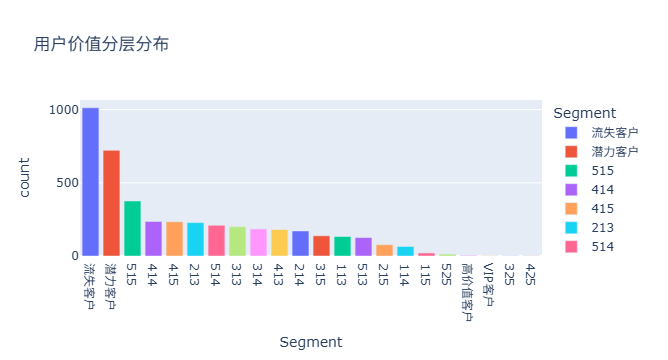

            Recency   Frequency      Monetary   用户数
Segment                                            
113      253.954887    1.977444    666.264135   133
114      244.400000    2.400000   1341.158308    65
115      255.952381    5.238095  10924.143857    21
213      114.385965    2.307018    682.467022   228
214      109.520468    3.304094   1372.111345   171
215      106.844156    5.480519   3589.073896    77
313       51.605000    2.510000    685.893700   200
314       52.178378    3.972973   1410.671405   185
315       50.963768    6.478261   3863.167899   138
325       39.000000   63.000000  81024.840000     1
413       23.436464    2.972376    697.977519   181
414       22.961864    4.669492   1407.567458   236
415       22.931624    9.068376   5398.095855   234
425       17.000000   51.000000  34684.400000     1
513        7.095238    3.134921    713.554524   126
514        5.995238    5.328571   1449.058905   210
515        5.757979   13.170213   7069.106995   376
525        4

In [42]:
# 1. 确保已生成 R_Score, F_Score, M_Score（字符串类型）
rfm['R_Score'] = rfm['R_Score'].astype(str)
rfm['F_Score'] = rfm['F_Score'].astype(str)
rfm['M_Score'] = rfm['M_Score'].astype(str)

# 2. 生成 RFM_Score 列（组合三个分数，例如 "555"、"342" 等）
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

# 3. 定义用户分层规则
segment_map = {
    r'5[4-5][4-5]': 'VIP客户',         # R=5, F=4-5, M=4-5
    r'[3-5][3-5][3-5]': '高价值客户',  # R=3-5, F=3-5, M=3-5
    r'[1-2][3-5][3-5]': '需唤回客户',  # R=1-2, F=3-5, M=3-5
    r'[3-5][1-2][1-2]': '潜力客户',    # R=3-5, F=1-2, M=1-2
    r'[1-2][1-2][1-2]': '流失客户'     # R=1-2, F=1-2, M=1-2
}

# 4. 应用分层规则
rfm['Segment'] = rfm['RFM_Score'].replace(segment_map, regex=True)

# 5. 处理未匹配到的用户（如果有的话）
rfm['Segment'] = rfm['Segment'].fillna('一般客户')  # 给未匹配的用户一个默认分类

# 6. 可视化用户分布
import plotly.express as px 
seg_counts = rfm['Segment'].value_counts().reset_index()
seg_counts.columns = ['Segment', 'count']  # 确保列名正确
fig = px.bar(seg_counts, x='Segment', y='count', color='Segment',
             title='用户价值分层分布')
fig.show()

# 7. 分析各层用户特征（注意：你的数据中用户ID列名可能是'Customer ID'而非'CustomerID'）
# 请根据实际列名修改（例如原数据中是'Customer ID'带空格）
segment_analysis = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'  # 修正为实际的用户ID列名
}).rename(columns={'CustomerID': '用户数'})

print(segment_analysis)

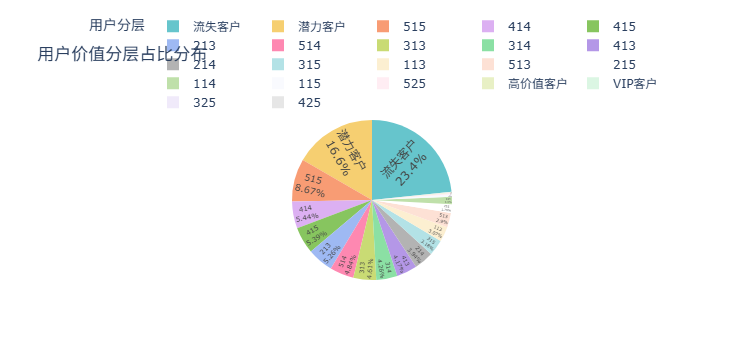

In [46]:
# 计算各分层的用户数量
seg_counts = rfm['Segment'].value_counts().reset_index()
seg_counts.columns = ['Segment', 'count']

# 计算各分层的占比（可选，用于在标签中显示百分比）
seg_counts['percentage'] = (seg_counts['count'] / seg_counts['count'].sum() * 100).round(2)

# 创建饼图
import plotly.express as px

fig = px.pie(
    seg_counts,
    values='count',
    names='Segment',
    title='用户价值分层占比分布',
    hover_data=['percentage'],  # 鼠标悬停时显示百分比
    labels={'percentage': '占比(%)'},  # 自定义悬停标签
    color_discrete_sequence=px.colors.qualitative.Pastel  # 使用柔和的颜色序列
)

# 优化饼图显示（在扇形上显示标签和百分比）
fig.update_traces(
    textinfo='label+percent',  # 显示标签和百分比
    textposition='inside',    # 标签位置在扇形内部
    insidetextorientation='radial'  # 文字径向排列
)

# 调整布局
fig.update_layout(
    legend_title_text='用户分层',  # 图例标题
    legend=dict(
        orientation="h",  # 水平排列图例
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

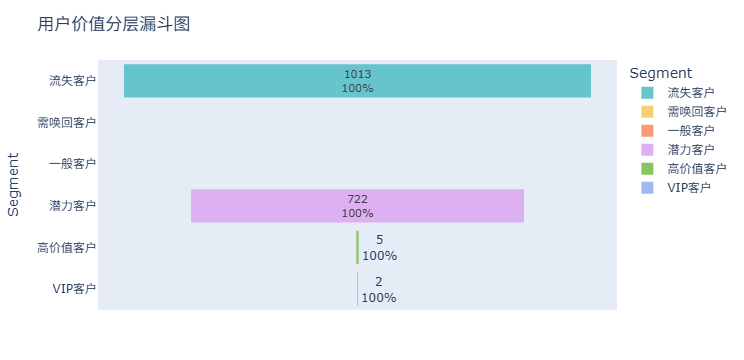

In [48]:
import plotly.express as px
import pandas as pd

# 1. 准备数据：统计各分层用户数量
seg_counts = rfm['Segment'].value_counts().reset_index()
seg_counts.columns = ['Segment', 'count']

# 2. 定义漏斗层级顺序（从底层“低价值”到顶层“高价值”）
# 按业务逻辑排序：流失客户 → 需唤回客户 → 一般客户 → 潜力客户 → 高价值客户 → VIP客户
funnel_order = [
    "流失客户", 
    "需唤回客户", 
    "一般客户", 
    "潜力客户", 
    "高价值客户", 
    "VIP客户"
]

# 3. 确保所有分层都被包含（缺失分层填充0）
full_seg_counts = pd.DataFrame({'Segment': funnel_order, 'count': 0})
for idx, row in seg_counts.iterrows():
    if row['Segment'] in full_seg_counts['Segment'].values:
        full_seg_counts.loc[full_seg_counts['Segment'] == row['Segment'], 'count'] = row['count']

# 4. 创建漏斗图
fig = px.funnel(
    full_seg_counts,
    x='count',  # 数值（用户数量）
    y='Segment',  # 分层名称
    color='Segment',  # 按分层着色
    title='用户价值分层漏斗图',
    color_discrete_sequence=px.colors.qualitative.Pastel  # 柔和的颜色序列
)

# 5. 强制按漏斗顺序显示（避免自动排序）
fig.update_layout(
    yaxis={
        'categoryorder': 'array',
        'categoryarray': funnel_order  # 按定义的顺序排列纵轴
    },
    font={'size': 12},
    margin={'l': 50, 'r': 50, 't': 60, 'b': 50}
)

# 6. 在漏斗上显示具体数值
fig.update_traces(textinfo='value+percent initial')  # 显示数量和占初始值的百分比

fig.show()